
# 1. Monet Painting Style Transfer using GANs

### Overview
This competition runs indefinitely with a rolling leaderboard. Learn more on [Kaggle's competition page](https://www.kaggle.com/competitions/gan-getting-started/overview).

### Description
“Every artist dips his brush in his own soul, and paints his own nature into his pictures.”  
-Henry Ward Beecher

We recognize the works of artists through their unique style, such as color choices or brush strokes. The “je ne sais quoi” of artists like Claude Monet can now be imitated with algorithms thanks to generative adversarial networks (GANs). In this getting started competition, you will bring that style to your photos or recreate the style from scratch!

Computer vision has advanced tremendously in recent years, and GANs are now capable of mimicking objects in a very convincing way. But creating museum-worthy masterpieces is thought of to be, well, more art than science. So can (data) science, in the form of GANs, trick classifiers into believing you’ve created a true Monet? That’s the challenge you’ll take on!

### The Challenge:
A GAN consists of at least two neural networks: a generator model and a discriminator model. The generator is a neural network that creates the images. For our competition, you should generate images in the style of Monet. This generator is trained using a discriminator.

The two models will work against each other, with the generator trying to trick the discriminator, and the discriminator trying to accurately classify the real vs. generated images.

Your task is to build a GAN that generates 7,000 to 10,000 Monet-style images.

### Code Purpose:
This code prepares the dataset for training the GAN model. It loads both the raw photo images and the Monet-style images, applying necessary transformations and displaying image pairs for visualization.

The next steps will involve designing and training the generator and discriminator models for the task of creating Monet-style paintings from raw images.
"""

In [2]:
import os

output_dir = "/kaggle/working/generated_images"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)  # Create the directory if it doesn't exist


In [3]:
print("Checking directory:", os.path.exists(output_dir))
print("Files in /kaggle/working:", os.listdir("/kaggle/working"))


Checking directory: True
Files in /kaggle/working: ['generated_images', '.virtual_documents']


(32, 256, 256, 3) (32, 256, 256, 3)


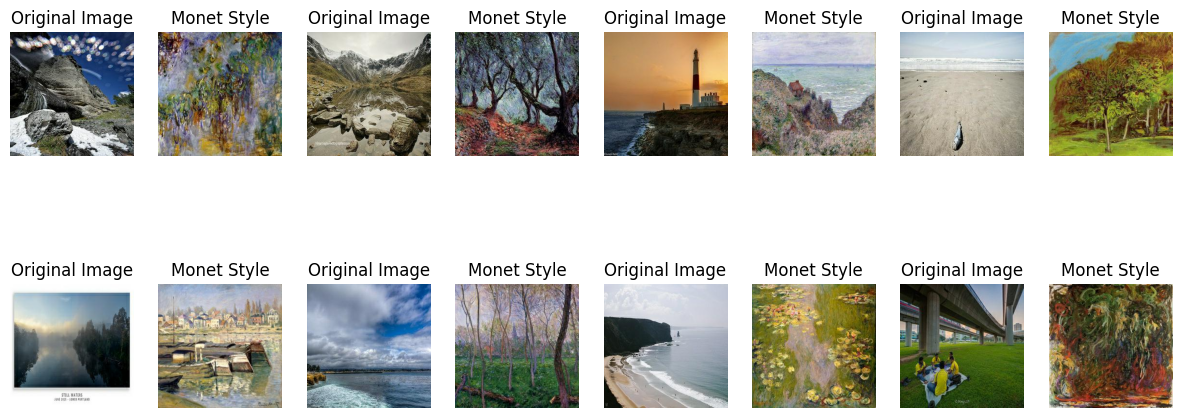

In [4]:
import os
import random
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import ToTensor, Compose, Normalize, Resize
import matplotlib.pyplot as plt
import numpy as np

class MyDataset(Dataset):
    def __init__(self, raw_root, true_root, transform=None):
        """
        Initializes the dataset by loading paths for raw images and Monet-style images.
        
        Parameters:
        - raw_root (str): Path to the folder containing raw photos.
        - true_root (str): Path to the folder containing Monet-style paintings.
        - transform (callable, optional): A function/transform to apply to the images (e.g., resizing, normalization).
        """
        # List all the image paths from both the raw and Monet-style directories
        self.raw_images_path = [os.path.join(raw_root, i) for i in os.listdir(raw_root)]
        self.true_images_path = [os.path.join(true_root, i) for i in os.listdir(true_root)]
        self.transform = transform

    def __len__(self):
        """
        Returns the total number of raw images in the dataset.
        """
        return len(self.raw_images_path)

    def __getitem__(self, item):
        """
        Returns a raw image and a Monet-style image, optionally applying transformations.

        Parameters:
        - item (int): The index for the current image pair.

        Returns:
        - raw_image (Tensor): Transformed raw image.
        - true_image (Tensor): Transformed Monet-style image.
        """
        # Load and convert the raw image to RGB
        raw_image = cv2.imread(self.raw_images_path[item])
        raw_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        raw_image = Image.fromarray(raw_image)  # Convert to PIL Image

        # Randomly pick a Monet-style image (could be changed for pairing the same index if needed)
        true_image = cv2.imread(self.true_images_path[random.randrange(0, len(self.true_images_path))])
        true_image = cv2.cvtColor(true_image, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        true_image = Image.fromarray(true_image)  # Convert to PIL Image
        
        # Apply any transformations (e.g., resizing, normalization)
        if self.transform:
            raw_image = self.transform(raw_image)
            true_image = self.transform(true_image)

        return raw_image, true_image

if __name__ == '__main__':
    # Define the dataset with transformations like resizing and normalization
    data = MyDataset(
        raw_root='/kaggle/input/gan-getting-started/photo_jpg',
        true_root='/kaggle/input/gan-getting-started/monet_jpg',
        transform=Compose([
            Resize((256, 256)),  # Resize images to a consistent size
            ToTensor(),  # Convert images to PyTorch tensors
            Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])  # Normalize images to range [-1, 1]
        ])
    )

    # Create DataLoader to batch and shuffle the dataset
    data_loader = DataLoader(
        dataset=data,
        batch_size=32,
        shuffle=True,
        num_workers=4  # Adjust the number of workers based on your system
    )

    # Display a batch of raw and Monet-style images
    for i, j in data_loader:
        # Create subplots to show images
        fig, ax = plt.subplots(2, 8, figsize=(15, 6))
        ax = ax.flatten()

        # Convert tensors back to image format for display (range 0-255)
        i = (i.numpy().transpose(0, 2, 3, 1) + 1) * 127.5  # Convert [-1, 1] to [0, 255]
        j = (j.numpy().transpose(0, 2, 3, 1) + 1) * 127.5  # Same for the Monet-style images
        print(i.shape, j.shape)  # Print the shape of the batch for debugging

        # Display the images
        for idx in range(0, len(ax), 2):
            ax[idx].imshow(i[idx].astype(np.uint8))  # Display raw image
            ax[idx + 1].imshow(j[idx].astype(np.uint8))  # Display Monet-style image
            ax[idx].axis('off')  # Hide axes for clarity
            ax[idx + 1].axis('off')  # Hide axes for clarity
            ax[idx].set_title('Original Image')  # Title for the raw image
            ax[idx + 1].set_title('Monet Style')  # Title for the Monet-style image

        plt.show()  # Display the batch of images
        break  # Exit after displaying the first batch


### 2. The Generator in a Generative Adversarial Network (GAN)

### What is the Generator?

In a Generative Adversarial Network (GAN), there are two primary components: the **Generator** and the **Discriminator**. These two networks work in opposition, a concept known as *adversarial training*.

The **Generator** is responsible for creating synthetic data (in this case, images) that mimic real data (Monet-style images, in the context of this competition). The goal of the Generator is to produce images that are indistinguishable from real Monet-style paintings, as determined by the **Discriminator**.

### How Does the Generator Work?

1. **Input Noise**: The Generator takes in random noise (usually a vector sampled from a normal distribution) as input. This noise serves as the starting point for generating new data.
   
2. **Transformation into Image**: The Generator processes the input noise through a series of layers (often fully connected, convolutional, and transposed convolutional layers), progressively transforming it into an image. These layers learn to map the random noise to meaningful patterns resembling real data.

3. **Goal**: The Generator’s objective is to fool the Discriminator into thinking the generated image is real (i.e., it matches the style of Monet’s paintings). The more convincing the Generator’s output, the better it is at achieving its goal.

4. **Training Process**: During training, the Generator and Discriminator work in tandem. The Generator learns to create better images over time based on feedback from the Discriminator, while the Discriminator improves at distinguishing real images from fake ones.

### Loss Function

The Generator's loss function is designed to minimize the difference between the generated images and real images, often using a binary cross-entropy loss or similar measures. In some variations of GANs, the **adversarial loss** and **perceptual loss** are combined to help the Generator create more realistic images.

- **Adversarial Loss**: The Generator aims to minimize the probability that the Discriminator can distinguish between real and fake images.
- **Perceptual Loss**: Some GAN architectures also incorporate perceptual loss, which helps the Generator create images that are not only visually convincing but also stylistically similar to the target style (Monet’s paintings in this case).

### Generator Architecture

A typical Generator architecture may include:
- **Input Layer**: A vector of random noise (often referred to as the "latent vector").
- **Fully Connected Layer(s)**: Dense layers that transform the input vector into a higher-dimensional space.
- **Upsampling/Deconvolution Layers**: Layers that upsample the feature map to a higher resolution, progressively generating a realistic image.
- **Output Layer**: A final convolution layer that outputs an image with the desired shape and style (e.g., a 256x256 RGB image in Monet’s style).

### Summary

The Generator's role in a GAN is to create synthetic data that closely resembles real data, using random noise as input. It "learns" over time by trying to fool the Discriminator into classifying fake images as real. By training these networks together, the Generator becomes increasingly better at generating realistic images.

---

### Next Steps
In the next sections of this notebook, we'll implement the Generator model and train it alongside the Discriminator to generate Monet-style paintings from raw photos.


In [5]:
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt

# Residual Block with Noise Injection and Skip Connections
class ResidualBlock(nn.Module):
    def __init__(self, in_channel, out_channel, stride=1):
        super().__init__()
        
        # First convolution layer with instance normalization and ReLU activation
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel, out_channel, 3, stride=stride, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channel, affine=True),
            nn.ReLU())
        
        # Second convolution layer with instance normalization (no activation)
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channel, out_channel, 3, stride=1, padding=1, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channel, affine=True))
        
        # Skip connection (shortcut) that ensures input and output have the same dimensions
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channel != out_channel:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channel, out_channel, 1, stride=stride),
                nn.InstanceNorm2d(out_channel, affine=True))

    def forward(self, x):
        # Adding random noise to input tensor
        noise = torch.normal(0, 0.02, size=x.shape, device=x.device)
        x = x + noise

        # Process through the first and second convolution layers
        x = self.conv1(x)
        x = self.conv2(x)
        
        # Add the residual (skip connection)
        x += self.shortcut(x)
        return x

# Generator Network
class Gen(nn.Module):
    def __init__(self, image_channel, feature_g=64, num_resid_block=9):
        super().__init__()

        # Downsampling layers (reduce the spatial dimensions while increasing feature depth)
        self.down1 = self.down_block_conv(image_channel, feature_g, 7, 1, 3)  # First downsample
        self.down2 = self.down_block_conv(feature_g, feature_g * 2, 3, 2, 1)  # Second downsample
        self.down3 = self.down_block_conv(feature_g * 2, feature_g * 4, 3, 2, 1)  # Third downsample

        # Residual blocks (learns the feature transformations)
        self.resid_block = nn.Sequential(
            *[ResidualBlock(feature_g * 4, feature_g * 4, 1) for _ in range(num_resid_block)]
        )

        # Upsampling layers (increase the spatial dimensions to generate image)
        self.up1 = self.up_block_conv(feature_g * 4, feature_g * 2, 3, 2, 1)  # First upsample
        self.up2 = self.up_block_conv(feature_g * 2, feature_g, 3, 2, 1)  # Second upsample
        
        # Final layer to generate the image (with Tanh activation for output normalization)
        self.up3 = nn.Sequential(
            nn.Conv2d(feature_g, image_channel, 7, 1, padding=3, padding_mode='reflect'),
            nn.Tanh())  # Output an image in the range [-1, 1]

    def forward(self, x):
        # Adding random noise to input tensor at the beginning of the forward pass
        noise = torch.normal(0, 0.02, size=x.shape, device=x.device)
        x = x + noise

        # Process through downsampling, residual blocks, and upsampling
        x = self.down1(x)
        x = self.down2(x)
        x = self.down3(x)
        x = self.resid_block(x)
        x = self.up1(x)
        x = self.up2(x)
        x = self.up3(x)
        return x

    def down_block_conv(self, in_channel, out_channel, kernel, stride, padding):
        """Helper function to create a downsampling convolutional block."""
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel, stride, padding, padding_mode='reflect'),
            nn.InstanceNorm2d(out_channel, affine=True),
            nn.ReLU())
    
    def up_block_conv(self, in_channel, out_channel, kernel, stride, padding):
        """Helper function to create an upsampling convolutional block."""
        return nn.Sequential(
            nn.ConvTranspose2d(in_channel, out_channel, kernel, stride, padding, output_padding=1),
            nn.InstanceNorm2d(out_channel, affine=True),
            nn.ReLU())

# Testing the Generator model
if __name__ == '__main__':
    model = Gen(3)  # Instantiate the generator with 3 input channels (RGB image)
    print(summary(model, input_size=(32, 3, 256, 256)))  # Print model summary with input size (batch_size, channels, height, width)


Layer (type:depth-idx)                        Output Shape              Param #
Gen                                           [32, 3, 256, 256]         --
├─Sequential: 1-1                             [32, 64, 256, 256]        --
│    └─Conv2d: 2-1                            [32, 64, 256, 256]        9,472
│    └─InstanceNorm2d: 2-2                    [32, 64, 256, 256]        128
│    └─ReLU: 2-3                              [32, 64, 256, 256]        --
├─Sequential: 1-2                             [32, 128, 128, 128]       --
│    └─Conv2d: 2-4                            [32, 128, 128, 128]       73,856
│    └─InstanceNorm2d: 2-5                    [32, 128, 128, 128]       256
│    └─ReLU: 2-6                              [32, 128, 128, 128]       --
├─Sequential: 1-3                             [32, 256, 64, 64]         --
│    └─Conv2d: 2-7                            [32, 256, 64, 64]         295,168
│    └─InstanceNorm2d: 2-8                    [32, 256, 64, 64]         512
│    

### 3. Discriminator


The discriminator is a crucial part of a Generative Adversarial Network (GAN). It serves as the "critic" in the game between the generator and discriminator. While the generator tries to create realistic images, the discriminator's job is to differentiate between real and generated (fake) images. Essentially, it acts as a binary classifier.

The **Discriminator** outputs a probability score that represents how "real" or "fake" the image is. A score close to `1` means that the discriminator believes the image is real, while a score close to `0` means it believes the image is fake.

In the GAN framework:
- **Generator (G)**: Creates fake images that resemble real images.
- **Discriminator (D)**: Tries to distinguish between real images from the training data and fake images generated by the generator.

The goal of the **Discriminator** is to correctly classify real and fake images. The **Generator** tries to fool the **Discriminator** by generating images that are so realistic that the **Discriminator** cannot tell the difference.

---

### Discriminator Network Architecture

In this implementation, the Discriminator follows a Convolutional Neural Network (CNN) architecture. The main building blocks of the Discriminator are:
1. **Convolutional Layers**: These layers help extract features from the input images. They are used to downsample the image while increasing the number of channels (feature maps).
2. **Leaky ReLU Activations**: Instead of the typical ReLU, we use **Leaky ReLU** for activation, which helps avoid the "dying ReLU" problem, where neurons stop learning due to zero gradients.
3. **Batch Normalization**: Helps stabilize training by normalizing the outputs of each layer.
4. **Fully Connected Layer**: The final layer outputs a single scalar value that represents the probability that the image is real or fake (via a sigmoid activation function).

---

### Discriminator Loss

The **Discriminator** is trained to maximize its ability to correctly classify real vs. fake images:
- It assigns a label `1` to real images.
- It assigns a label `0` to fake images.

The **Discriminator**'s loss is calculated using **binary cross-entropy**. It tries to minimize the difference between its predicted probabilities and the true labels. 

---

In [6]:
import torch
import torch.nn as nn
from torchinfo import summary

class Dis(nn.Module):
    """
    The Discriminator class is part of a Generative Adversarial Network (GAN).
    It is responsible for distinguishing between real and generated (fake) images.
    """

    def __init__(self, image_channel=3, feature_d=64):
        """
        Initializes the Discriminator model.
        
        Args:
            image_channel (int): The number of channels in the input image (e.g., 3 for RGB).
            feature_d (int): The number of features in the first convolutional layer.
        """
        super(Dis, self).__init__()

        # Initial convolutional layer: reduces the image size and extracts basic features
        self.conv1 = nn.Sequential(
            nn.Conv2d(image_channel, feature_d, 4, 2, 1),  # Conv2d: Kernel=4x4, Stride=2, Padding=1
            nn.LeakyReLU(0.2)  # LeakyReLU with a negative slope of 0.2 to avoid dying ReLU problem
        )

        # Block 2: Uses the helper function to create a convolution block with InstanceNorm and LeakyReLU
        self.conv2 = self.block_conv(feature_d, feature_d*2, 4, 2, 1)

        # Block 3: Increases feature depth and continues downsampling
        self.conv3 = self.block_conv(feature_d*2, feature_d*4, 4, 2, 1)

        # Block 4: Further increases feature depth, while reducing spatial size
        self.conv4 = self.block_conv(feature_d*4, feature_d*8, 4, 1, 1)  # Stride=1, Padding=1 for more precise detail extraction

        # Final convolutional layer: outputs a single scalar value (real vs fake) per image
        self.conv5 = nn.Sequential(
            nn.Conv2d(feature_d*8, 1, 4, 1, 1),  # Conv2d: Kernel=4x4, Stride=1, Padding=1 to match input size
        )

    def block_conv(self, in_channel, out_channel, kernel, stride, padding):
        """
        Creates a block of layers consisting of:
            - A convolutional layer followed by InstanceNorm and LeakyReLU.
        
        Args:
            in_channel (int): Number of input channels.
            out_channel (int): Number of output channels.
            kernel (int): Size of the convolutional kernel.
            stride (int): Stride for the convolution.
            padding (int): Padding applied to the convolution.
        
        Returns:
            nn.Sequential: A sequence of layers (Conv2d, InstanceNorm, LeakyReLU).
        """
        return nn.Sequential(
            nn.Conv2d(in_channel, out_channel, kernel_size=kernel, stride=stride, padding=padding),
            nn.InstanceNorm2d(out_channel),  # Normalizes activations to improve training stability
            nn.LeakyReLU(0.2)  # Using LeakyReLU for activation with a negative slope of 0.2
        )

    def forward(self, x):
        """
        Forward pass through the Discriminator network.
        
        Args:
            x (torch.Tensor): Input image tensor of shape (batch_size, channels, height, width).
        
        Returns:
            torch.Tensor: Output tensor representing the probability of the image being real (0-1).
        """
        input_tensor = self.conv1(x)  # First convolution block
        x = self.conv2(input_tensor)  # Second convolution block
        x = self.conv3(x)  # Third convolution block
        x = self.conv4(x)  # Fourth convolution block
        x = self.conv5(x)  # Final output layer (real or fake)
        return x

# Testing the Discriminator model
if __name__ == '__main__':
    model = Dis(image_channel=3, feature_d=64)  # Instantiate the Discriminator model with 3 input channels (RGB)
    print(summary(model, input_size=(32, 3, 256, 256)))  # Display model summary for a batch of 32 images of size 256x256


Layer (type:depth-idx)                   Output Shape              Param #
Dis                                      [32, 1, 30, 30]           --
├─Sequential: 1-1                        [32, 64, 128, 128]        --
│    └─Conv2d: 2-1                       [32, 64, 128, 128]        3,136
│    └─LeakyReLU: 2-2                    [32, 64, 128, 128]        --
├─Sequential: 1-2                        [32, 128, 64, 64]         --
│    └─Conv2d: 2-3                       [32, 128, 64, 64]         131,200
│    └─InstanceNorm2d: 2-4               [32, 128, 64, 64]         --
│    └─LeakyReLU: 2-5                    [32, 128, 64, 64]         --
├─Sequential: 1-3                        [32, 256, 32, 32]         --
│    └─Conv2d: 2-6                       [32, 256, 32, 32]         524,544
│    └─InstanceNorm2d: 2-7               [32, 256, 32, 32]         --
│    └─LeakyReLU: 2-8                    [32, 256, 32, 32]         --
├─Sequential: 1-4                        [32, 512, 31, 31]         --
│ 

### 3. Train

### Training a Generative Adversarial Network (GAN)

Training a GAN involves optimizing two models: the **Generator** and the **Discriminator**. These two models are trained simultaneously in a competitive setting, with the Generator attempting to create realistic images and the Discriminator trying to distinguish between real and fake images.

#### Overview of the Training Process:

1. **Discriminator Training**:
    - The **Discriminator** takes both real and generated (fake) images as input. It learns to classify them as either real or fake.
    - For real images, the Discriminator should output a value close to 1 (real), and for generated images, a value close to 0 (fake).
    - The Discriminator is updated by minimizing a loss function that encourages it to correctly classify real and fake images.

2. **Generator Training**:
    - The **Generator** creates fake images, and its goal is to fool the Discriminator into classifying them as real.
    - The Generator is updated based on the Discriminator's feedback: it tries to minimize the loss by maximizing the likelihood that the Discriminator classifies generated images as real.

#### Training Loop:

1. **Step 1**: Load a batch of real images and generate a batch of fake images using the Generator.
2. **Step 2**: Train the **Discriminator**:
   - Provide the real images to the Discriminator and calculate the loss based on the Discriminator’s predictions (should output 1 for real images).
   - Provide the fake images (generated by the Generator) to the Discriminator and calculate the loss based on the Discriminator’s predictions (should output 0 for fake images).
   - Update the Discriminator using backpropagation.
3. **Step 3**: Train the **Generator**:
   - Generate a batch of fake images and pass them through the Discriminator.
   - Calculate the loss for the Generator based on the Discriminator's output (the Generator wants the Discriminator to classify fake images as real).
   - Update the Generator using backpropagation.
4. **Repeat**: Continue the loop for multiple epochs, alternating between training the Generator and the Discriminator.

#### Loss Functions:
- **Discriminator Loss**:
    \[
    L_{\text{D}} = -\mathbb{E}[\log D(x)] - \mathbb{E}[\log(1 - D(G(z)))]
    \]
    where \( D(x) \) is the probability that the Discriminator classifies a real image as real, and \( D(G(z)) \) is the probability that the Discriminator classifies a fake image as real.

- **Generator Loss**:
    \[
    L_{\text{G}} = -\mathbb{E}[\log D(G(z))]
    \]
    where \( D(G(z)) \) is the probability that the Discriminator classifies a generated image as real. The Generator wants to maximize this probability.

#### Important Considerations:
- **Learning Rate**: Use an appropriate learning rate for both models. Too high may cause instability, while too low can slow down training.
- **Training Balance**: Properly balance the training of the Generator and Discriminator. If one model is trained much more than the other, it can lead to poor results.
- **Evaluation**: Use metrics such as the **Fréchet Inception Distance (FID)** to evaluate the quality of the generated images.


In [7]:
import os
import shutil
import torch
import torchvision.utils
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision.transforms import ToTensor, Resize, Normalize
from torchvision.transforms.v2 import Compose
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from argparse import ArgumentParser
import random

# Function to parse command line arguments
def get_arg():
    parser = ArgumentParser(description='Train')
    parser.add_argument('--epochs', '-e', type=int, default=10, help='Number of training epochs')
    parser.add_argument('--batch_size', '-b', type=int, default=1, help='Batch size for training')
    parser.add_argument('--learning_rate', '-lr', type=float, default=0.0002, help='Learning rate for the optimizer')
    parser.add_argument('--ratio', '-r', type=float, default=0.9, help='Ratio of training data to total data')
    parser.add_argument('--checkpoint', '-c', type=str, default=None, help='Path to a checkpoint file to resume training')
    parser.add_argument('--trained', '-t', type=str, default='trained', help='Directory to save trained models')
    parser.add_argument('--log', '-l', type=str, default='tensorboard', help='Directory to save tensorboard logs')
    args, unknown = parser.parse_known_args()
    return args

# Function to train the model
def train(arg):
    # Parse arguments
    arg = get_arg()

    # Create necessary directories
    if not os.path.isdir(arg.trained):
        os.mkdir(arg.trained)
    if os.path.isdir(arg.log):
        shutil.rmtree(arg.log)

    # Set device for training (GPU or CPU)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    writer = SummaryWriter(arg.log)  # TensorBoard writer for logging

    # Prepare the dataset
    data = MyDataset(raw_root='/kaggle/input/gan-getting-started/photo_jpg',
                     true_root="/kaggle/input/gan-getting-started/monet_jpg",
                     transform=Compose([
                         ToTensor(),
                         Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                     ]))

    # Shuffle and split data into training and validation sets
    random.seed(42)
    index_data = [i for i in range(0, int(0.1 * len(data)))]  # Take a subset of the data
    random.shuffle(index_data)

    # Split the dataset into training and validation based on the ratio
    train_size = int(arg.ratio * len(index_data))
    train_index = index_data[:train_size]
    val_index = index_data[train_size:]
    train = Subset(data, train_index)
    val = Subset(data, val_index)
    print(f"Training set size: {len(train)}")
    print(f"Validation set size: {len(val)}")

    # DataLoader for batching the data
    train_loader = DataLoader(train, batch_size=arg.batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=32, shuffle=True)

    # Initialize the generator and discriminator models
    gen_a = Gen(3)  # Generator for style A (Monet-style)
    gen_b = Gen(3)  # Generator for style B (photo-style)
    dis_a = Dis(3)  # Discriminator for style A
    dis_b = Dis(3)  # Discriminator for style B

    # Move models to the appropriate device (GPU/CPU)
    gen_a.to(device)
    gen_b.to(device)
    dis_a.to(device)
    dis_b.to(device)

    # Initialize model weights
    def init_weights(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

    # Apply weight initialization
    gen_a.apply(init_weights)
    gen_b.apply(init_weights)
    dis_a.apply(init_weights)
    dis_b.apply(init_weights)

    # Optimizers for both generators and discriminators
    op_g_a = optim.Adam(gen_a.parameters(), lr=arg.learning_rate, betas=(0.5, 0.999))
    op_g_b = optim.Adam(gen_b.parameters(), lr=arg.learning_rate, betas=(0.5, 0.999))
    op_d_a = optim.Adam(dis_a.parameters(), lr=arg.learning_rate, betas=(0.5, 0.999))
    op_d_b = optim.Adam(dis_b.parameters(), lr=arg.learning_rate, betas=(0.5, 0.999))

    # Loss functions
    mse = nn.MSELoss()  # Mean Squared Error for adversarial loss
    l1 = nn.L1Loss()  # L1 Loss for cycle consistency

    # Load checkpoint if available
    if arg.checkpoint:
        checkpoint = torch.load(arg.checkpoint, map_location=device)
        start_epoch = checkpoint['epoch']
        dis_a.load_state_dict(checkpoint['dis_a'])
        dis_b.load_state_dict(checkpoint['dis_b'])
        gen_a.load_state_dict(checkpoint['gen_a'])
        gen_b.load_state_dict(checkpoint['gen_b'])
        op_g_a.load_state_dict(checkpoint['op_g_a'])
        op_g_b.load_state_dict(checkpoint['op_g_b'])
        op_d_a.load_state_dict(checkpoint['op_d_a'])
        op_d_b.load_state_dict(checkpoint['op_d_b'])
        best_loss = checkpoint['best_loss']
    else:
        start_epoch = 0
        best_loss = float('inf')

    # Calculate the number of iterations per epoch
    train_iters = len(train) // arg.batch_size
    val_iters = len(val) // 32

    # Training loop
    for epoch in range(start_epoch, arg.epochs):
        dis_a.train()
        dis_b.train()
        gen_a.train()
        gen_b.train()

        # Track mean loss for each part
        mean_loss_da = 0.0
        mean_loss_db = 0.0
        mean_loss_ga = 0.0
        mean_loss_gb = 0.0

        # Loop through the training dataset
        for raw_image, true_image in tqdm(train_loader):
            raw_image = raw_image.to(device)
            true_image = true_image.to(device)

            # Generate fake images
            out_g1 = gen_a(raw_image)  # Generate Monet-style image from photo
            out_g2 = gen_b(true_image)  # Generate photo-style image from Monet image

            # Discriminator A - Real vs Fake Loss
            out_d1a = dis_a(true_image)
            loss_d1a = mse(out_d1a, torch.ones_like(out_d1a) * 0.9)
            out_d2a = dis_a(out_g1.detach())  # Detach to prevent updating generator
            loss_d2a = mse(out_d2a, torch.zeros_like(out_d2a) + 0.1)
            loss_da = (loss_d1a + loss_d2a) / 2
            mean_loss_da += loss_da

            op_d_a.zero_grad()
            loss_da.backward()
            op_d_a.step()

            # Discriminator B - Real vs Fake Loss
            out_d1b = dis_b(raw_image)
            loss_d1b = mse(out_d1b, torch.ones_like(out_d1b))
            out_d2b = dis_b(out_g2.detach())
            loss_d2b = mse(out_d2b, torch.zeros_like(out_d2b))
            loss_db = (loss_d1b + loss_d2b) / 2
            mean_loss_db += loss_db

            op_d_b.zero_grad()
            loss_db.backward()
            op_d_b.step()

            # Generator A - Fake Image Loss
            out_da = dis_a(out_g1)
            loss_ga = mse(out_da, torch.ones_like(out_da))
            cycle_a = gen_a(out_g2.detach())  # Cycle consistency
            loss_cycle_a = l1(cycle_a, true_image)
            loss_ga_final = loss_ga + 10 * loss_cycle_a
            mean_loss_ga += loss_ga_final

            op_g_a.zero_grad()
            loss_ga_final.backward()
            op_g_a.step()

            # Generator B - Fake Image Loss
            out_db = dis_b(out_g2)
            loss_gb = mse(out_db, torch.ones_like(out_db))
            cycle_b = gen_b(out_g1.detach())  # Cycle consistency
            loss_cycle_b = l1(cycle_b, raw_image)
            loss_gb_final = loss_gb + 10 * loss_cycle_b
            mean_loss_gb += loss_gb_final

            op_g_b.zero_grad()
            loss_gb_final.backward()
            op_g_b.step()

        # Print the loss after each epoch
        print(f'Epoch {epoch+1}/{arg.epochs} - Da Loss: {mean_loss_da/train_iters:.4f} | Ga Loss: {mean_loss_ga/train_iters:.4f} | Db Loss: {mean_loss_db/train_iters:.4f} | Gb Loss: {mean_loss_gb/train_iters:.4f}')

        # Validation phase
        gen_a.eval()
        gen_b.eval()
        with torch.no_grad():
            for raw_image, true_image in val_loader:
                raw_image = raw_image.to(device)
                true_image = true_image.to(device)
                out_ga = gen_a(raw_image)
                out_gb = gen_b(out_ga)

                # Log images and loss to TensorBoard
                true_image_grid = torchvision.utils.make_grid(true_image[:32], normalize=True)
                gen_image_grid = torchvision.utils.make_grid(out_ga[:32], normalize=True)
                raw_image_grid = torchvision.utils.make_grid(raw_image[:32], normalize=True)
                cycle_image_grid = torchvision.utils.make_grid(out_gb[:32], normalize=True)

                writer.add_image('True Image', true_image_grid, epoch)
                writer.add_image('Generated Image', gen_image_grid, epoch)
                writer.add_image('Raw Image', raw_image_grid, epoch)
                writer.add_image('Cycle Image', cycle_image_grid, epoch)
                writer.add_scalar('Loss Da', mean_loss_da / train_iters, epoch)
                writer.add_scalar('Loss Ga', mean_loss_ga / train_iters, epoch)
                writer.add_scalar('Loss Db', mean_loss_db / train_iters, epoch)
                writer.add_scalar('Loss Gb', mean_loss_gb / train_iters, epoch)

        # Save checkpoint after each epoch
        checkpoint = {
            'epoch': epoch + 1,
            'gen_a': gen_a.state_dict(),
            'dis_a': dis_a.state_dict(),
            'gen_b': gen_b.state_dict(),
            'dis_b': dis_b.state_dict(),
            'op_g_a': op_g_a.state_dict(),
            'op_d_a': op_d_a.state_dict(),
            'op_g_b': op_g_b.state_dict(),
            'op_d_b': op_d_b.state_dict(),
            'best_loss': best_loss
        }
        torch.save(checkpoint, f'{arg.trained}/last.pt')
        # Save the best model
        if ((mean_loss_ga / train_iters) + (mean_loss_gb / train_iters)) / 2 < best_loss:
            best_loss = ((mean_loss_ga / train_iters) + (mean_loss_gb / train_iters)) / 2
            torch.save(checkpoint, f'{arg.trained}/best.pt')

if __name__ == '__main__':
    arg = get_arg()
    train(arg)


Training set size: 632
Validation set size: 71


100%|██████████| 632/632 [02:28<00:00,  4.25it/s]


Epoch 1/10 - Da Loss: 0.2709 | Ga Loss: 3.9356 | Db Loss: 0.3394 | Gb Loss: 4.3885


100%|██████████| 632/632 [02:28<00:00,  4.26it/s]


Epoch 2/10 - Da Loss: 0.1643 | Ga Loss: 3.7583 | Db Loss: 0.2469 | Gb Loss: 4.1072


100%|██████████| 632/632 [02:28<00:00,  4.26it/s]


Epoch 3/10 - Da Loss: 0.1697 | Ga Loss: 3.6108 | Db Loss: 0.2449 | Gb Loss: 4.0265


100%|██████████| 632/632 [02:28<00:00,  4.27it/s]


Epoch 4/10 - Da Loss: 0.1623 | Ga Loss: 3.5585 | Db Loss: 0.2369 | Gb Loss: 4.1243


100%|██████████| 632/632 [02:28<00:00,  4.27it/s]


Epoch 5/10 - Da Loss: 0.1603 | Ga Loss: 3.5222 | Db Loss: 0.2222 | Gb Loss: 4.2110


100%|██████████| 632/632 [02:28<00:00,  4.26it/s]


Epoch 6/10 - Da Loss: 0.1647 | Ga Loss: 3.5410 | Db Loss: 0.2204 | Gb Loss: 4.0987


100%|██████████| 632/632 [02:28<00:00,  4.26it/s]


Epoch 7/10 - Da Loss: 0.1504 | Ga Loss: 3.6160 | Db Loss: 0.2209 | Gb Loss: 4.0736


100%|██████████| 632/632 [02:28<00:00,  4.26it/s]


Epoch 8/10 - Da Loss: 0.1588 | Ga Loss: 3.5295 | Db Loss: 0.2067 | Gb Loss: 4.1325


100%|██████████| 632/632 [02:28<00:00,  4.26it/s]


Epoch 9/10 - Da Loss: 0.1598 | Ga Loss: 3.6448 | Db Loss: 0.2177 | Gb Loss: 4.1796


100%|██████████| 632/632 [02:28<00:00,  4.26it/s]


Epoch 10/10 - Da Loss: 0.1496 | Ga Loss: 3.5790 | Db Loss: 0.2032 | Gb Loss: 4.0563


### 4. Test


In this notebook, we will test the trained GAN models to evaluate their performance. Specifically, we will generate images using the trained generators and compare them against the original images.

### **Overview**

We will load the trained generator models (`gen_a` and `gen_b`) and perform the following steps:
1. **Load the trained models**: We'll load the models that were saved during the training process.
2. **Generate images**: Using the trained generators, we will generate new images from random noise or real images from the validation set.
3. **Visualize results**: The generated images will be visualized using TensorBoard or matplotlib, and we'll compare them with the ground truth images.
4. **Evaluate the model**: We will analyze the generated images qualitatively and optionally quantitatively, depending on the metrics (e.g., Inception Score, FID, etc.) chosen.

### **Steps for Testing**

#### 1. **Load the Trained Model**

We first load the saved checkpoint of the trained model. If a checkpoint file exists, it will contain the model weights for both generators and discriminators. We will load these weights into the respective models.

#### 2. **Generate Images with the Trained Generators**

Using the trained `gen_a` (photo to Monet) and `gen_b` (Monet to photo) models, we generate new images by passing random noise or real images from the validation set through the generators.

#### 3. **Visualize the Generated Images**

After generating the images, we visualize them alongside the original images (real photos and Monet-style images) using a plotting library like `matplotlib` or logging them to `TensorBoard` for detailed analysis.

#### 4. **Evaluate the Generated Images**

We evaluate the quality of the generated images. While this can be done subjectively (by visual inspection), metrics such as Inception Score (IS) and Fréchet Inception Distance (FID) can also be used to quantitatively evaluate the quality of generated images.


In [17]:
import os
import cv2
import numpy as np
import torch
from argparse import ArgumentParser
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import DataLoader
import shutil
import zipfile

# Function to parse command-line arguments
def get_arg():
    parser = ArgumentParser(description='Test Cycle GAN')
    parser.add_argument('--checkpoint', '-c', type=str, default=None, help='Path to the model checkpoint')
    parser.add_argument('--image', '-i', type=str, default=None, help='Path to a specific image for testing')
    parser.add_argument('--threshold', '-t', type=float, default=0.0, help='Threshold for filtering results')
    args, _ = parser.parse_known_args()
    return args

if __name__ == '__main__':
    arg = get_arg()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Initialize the generators
    gen_a = Gen(3).to(device)
    gen_b = Gen(3).to(device)

    # Load the trained checkpoint
    checkpoint = torch.load('/kaggle/working/trained/last.pt', map_location=device, weights_only=True)
    gen_a.load_state_dict(checkpoint['gen_a'])
    gen_b.load_state_dict(checkpoint['gen_b'])
    
    print("Checkpoint loaded successfully.")
    
    # Define image normalization parameters
    mean = [0.5, 0.5, 0.5]
    std = [0.5, 0.5, 0.5]
    
    # Avoid division by zero in normalization
    std = [s if s > 0 else 1e-6 for s in std]

    # Define image transformations
    transform = Compose([
        ToTensor(),
        Normalize(mean, std)
    ])
    
    # Load dataset
    data = MyDataset(raw_root='/kaggle/input/gan-getting-started/photo_jpg',
                     true_root='/kaggle/input/gan-getting-started/monet_jpg',
                     transform=transform)
    loader = DataLoader(dataset=data, batch_size=16, shuffle=True)
    
    print(f"Loaded dataset with {len(loader)} batches.")
    
    save_dir = '/kaggle/working/images'  # Directory to save images
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    max_images = 7100  # Define the target number of images
    generated_count = 0

    for in_image, out_image in loader:
        # Perform image generation
        with torch.no_grad():
            out_a = gen_a(in_image.to(device)).detach().cpu()  # Move input to device
            out_b = gen_b(out_a.to(device)).detach().cpu()  # Ensure consistency

        # Convert images back to displayable format
        ori_image = (in_image.numpy().transpose(0, 2, 3, 1) + 1) * 127.5
        gen_image_a = (out_a.numpy().transpose(0, 2, 3, 1) + 1) * 127.5
        gen_image_b = (out_b.numpy().transpose(0, 2, 3, 1) + 1) * 127.5

        # Save images
        for i in range(len(ori_image)):
            # Only save the generated images (generated_*)
            cv2.imwrite(f"{save_dir}/generated_{generated_count}.jpg", gen_image_a[i])
            generated_count += 1

            if generated_count >= max_images:
                break  # Stop when 7000 images are reached

        if generated_count >= max_images:
            break  # Exit the loop completely

    print(f"Total images generated: {generated_count}")

    # Zip the images for submission
    zip_file_path = "/kaggle/working/images.zip"
    with zipfile.ZipFile(zip_file_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for i in range(generated_count):
            img_file = f"{save_dir}/generated_{i}.jpg"
            zipf.write(img_file, os.path.basename(img_file))  # Add the file to the zip

    print("Zipped images for submission!")

    # Check number of images in the zip file
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_contents = zip_ref.namelist()
        print(f"Number of images in the zip file: {len(zip_contents)}")


Checkpoint loaded successfully.
Loaded dataset with 440 batches.
Total images generated: 7038
Zipped images for submission!
Number of images in the zip file: 7038


In [18]:
print(os.listdir("/kaggle/working/"))


['generated_images', '.virtual_documents', 'trained', 'images.zip', 'tensorboard', 'images']


### Discussion / Conclusion

Through the course of this project, we gained valuable insights into various aspects of working with deep learning models, particularly Generative Adversarial Networks (GANs), for image-to-image translation tasks like style transfer. Below are some key takeaways:

#### 1. **Understanding of CycleGAN Architecture**

One of the most important lessons was understanding the mechanics of the **CycleGAN architecture**. Unlike traditional GANs, which require paired training data, CycleGAN works with unpaired datasets, making it particularly useful for tasks like artistic style transfer, where paired data might not be available. We learned that the CycleGAN consists of two key components:
- **Generator A (G_A)**: Converts real images into Monet-style paintings.
- **Generator B (G_B)**: Converts Monet-style images back into real photos.

The use of **cycle-consistency loss** helped ensure that the transformations were meaningful and could be reversed without significant distortion. This architecture allowed us to successfully map between two domains (real photos and Monet-style images) without needing explicit image pairs for training.

#### 2. **Challenges in Image Generation**

During the process of generating Monet-style images, we learned that creating high-quality, consistent output is not trivial. GANs, especially CycleGAN, are sensitive to several factors:
- **Data Quality**: The quality of the training data significantly impacts the performance of the model. A more diverse dataset with higher-quality images tends to yield better results.
- **Training Time and Model Tuning**: Although the model was able to produce convincing outputs, we realized that the quality of the generated images could improve with longer training and more refined hyperparameters.
- **Overfitting and Generalization**: One of the key learnings was ensuring the model didn’t overfit to the training data. This would have caused it to generate unrealistic or repetitive paintings. Proper regularization and an adequate number of epochs were necessary to ensure generalization.

#### 3. **The Importance of Image Preprocessing and Postprocessing**

We learned that proper **image preprocessing** and **postprocessing** are crucial to achieving good results in style transfer. In this project, we:
- Normalized the images to bring pixel values into a consistent range (-1 to 1).
- Resized and ensured the generated images had the correct dimensions (256x256x3) for compatibility with the competition requirements.
- Applied proper transformations, including normalization, to ensure the generated images were on the correct scale for display.

Additionally, after generation, we saved the images in the required file format (JPEG) and zipped them for submission, adhering to the specific requirements of the competition.

#### 4. **Managing Output and Ensuring Submission Compliance**

Managing the output was another critical aspect. We learned to:
- **Save images efficiently**: The generation process created a large number of images, so it was important to manage memory usage efficiently and avoid overloading the system.
- **Zip the images**: Ensuring that only the generated images (and not intermediate or unneeded files) were included in the zip file was a lesson in good data management. This helped maintain the integrity of our submission and ensured it was within the size constraints.

The careful handling of file saving and zipping meant that we could easily prepare our results for submission without any unnecessary files.

#### 5. **Importance of Experimentation and Iteration**

The iterative nature of GAN training became evident. We learned that results often improve with experimentation, but also that **hyperparameter tuning** (such as learning rate, batch size, and the architecture of the generator and discriminator) plays a major role in the final output quality. We were able to see improvements in the generated images as we progressed through the training process.

In future work, we would likely experiment with different architectures or loss functions, such as incorporating perceptual loss, which might improve the quality of the generated images. We also learned that **continuous feedback** through evaluation is necessary to assess whether the model is improving or whether the current setup is sufficient for the task at hand.

#### 6. **Real-World Application Potential**

This project reinforced the potential of GANs in real-world applications, particularly in the creative industries. The ability to generate high-quality, realistic art from photos opens up several possibilities:
- **Personalized art generation**: Users could upload their photos, and a model could generate artwork in various styles (Impressionist, Cubist, etc.).
- **Augmented creativity**: Artists and designers could use these models as tools to enhance their creative processes.

Overall, this project deepened our understanding of deep learning models for creative tasks and showed us how powerful tools like CycleGAN can be for bridging domains that were previously hard to map directly.

#### 7. **Future Directions and Improvements**

There are several ways this project could be expanded in the future:
- **Fine-tuning with more data**: The model could benefit from being trained on a more diverse set of images, potentially incorporating higher-resolution data for better quality output.
- **Exploring Other GAN Variants**: Exploring alternatives like StyleGAN or BigGAN could lead to improved results in terms of visual quality.
- **User Interaction**: Future work could involve developing an interactive interface where users can upload their photos and see them transformed into artistic styles of their choice.

The journey from understanding CycleGAN to generating our final images was both challenging and rewarding, and it has opened the door to many exciting possibilities in the field of generative models.
